# Análise Exploratória dos Dados

## Setup

In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns 
from matplotlib import rcParams
from math import inf
from shutil import copy2

# Matplotlib options
rcParams['figure.figsize'] = (10, 8)
rcParams['axes.grid'] = False
plt.style.use('seaborn-deep')

# Pandas setup
pd.set_option('display.max_columns', 1000)
pd.set_option('display.max_rows', 1000) 
pd.set_option('display.max_colwidth', -1) 

In [2]:
# Read file
path = "./Tidy_Entities/"
name = "reator"
filename = name + ".csv"
df = pd.read_csv(path + filename, encoding='utf8')

# Transformations
df["DATE"] =  pd.to_datetime(df["DATE"], format="%Y-%m-%d")
df = df.sort_values("DATE").set_index("DATE")
df.drop(columns=["ENTIDADE"], inplace=True)

## Verificar Informações do Dataset

In [3]:
df.dtypes

ACIDEZ          float64
ALCALINIDADE    float64
dtype: object

In [4]:
print(
    f"\033[31mLinhas: {df.shape[0]}\n"
    f"Colunas: {df.shape[1]}\n\n"
    f"\033[32m-> Variáveis: \n{df.columns.tolist()}\n\n"
    f"\033[34m-> Valores ÚNICOS: \n{df.nunique().sort_values(ascending=False)}\n\n"
    f"\033[36m-> Valores FALTANTES: \n{df.isnull().sum().sort_values(ascending=True)}\033[0"
)

Linhas: 83
Colunas: 2

-> Variáveis: 
['ACIDEZ', 'ALCALINIDADE']

-> Valores ÚNICOS: 
ALCALINIDADE    69
ACIDEZ          62
dtype: int64

-> Valores FALTANTES: 
ACIDEZ          14
ALCALINIDADE    14
dtype: int64[0


### Selecionar features com no mínimo 60% de valores VÁLIDOS || 40% NULOS

In [5]:
# Remove colunas com percentual de nulos acima do limite
aux = pd.DataFrame(df.isnull().sum() / df.shape[0], columns=["NULL_COUNT"])
null_ratio = .40 # limite
features = aux[aux["NULL_COUNT"] <= null_ratio].index.tolist()
filtered = df[features]

print(
    f"{df.shape[1] - df[features].shape[1]} colunas removidas:\n"
    f"{set(df.columns) - set(features)}\n"
)

0 colunas removidas:
set()



In [6]:
# Ordena os features por quantidade de nulos
threshold = (1 - df.isnull().sum() / df.shape[0]) 
threshold = pd.Series(np.around(threshold.values, 2), index=threshold.index)
threshold = threshold.sort_values(ascending=False)

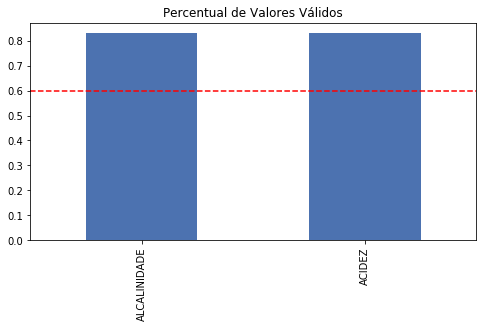

In [7]:
# Plota o diff dos valores selecionados e excluídos
plt.figure(figsize=(5,2))
threshold.plot.bar(figsize=(8, 4))

# Insere barra horizontal no limiar dos features selecionados
plt.axhline(y=(1 - null_ratio), color="red", linewidth=1.5, linestyle="--")
plt.xticks(rotation=90)
plt.title("Percentual de Valores Válidos");

## Análise de Séries Históricas

### Verificar valores faltantes na série histórica

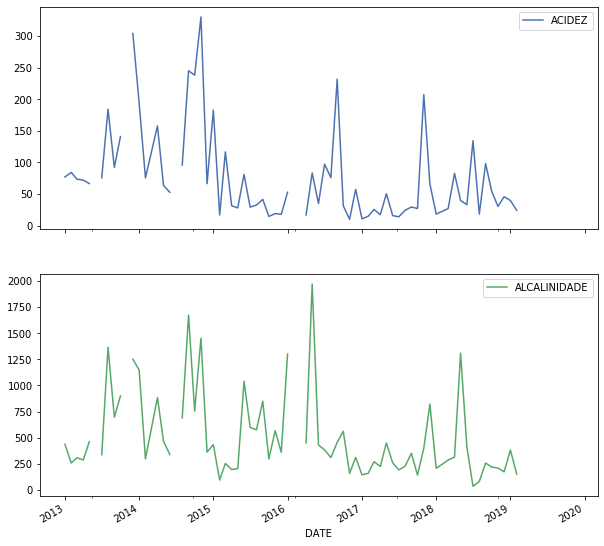

In [8]:
filtered.plot(subplots=True, figsize=(10, 10));

### Plotar séries históricas agregando por média anual, intervalo de confiança 95%


In [9]:
# Ordenando dados
ordered_columns = filtered.isnull().sum().sort_values(ascending=True).index
df_ordered = filtered[ordered_columns]
df_ordered["YEAR"] = [timestamp.year for timestamp in df_ordered.index]
cols = df_ordered.columns[:-1]
# Removendo ano de 2019 para validação do modelo de predição
validation = df_ordered.query("YEAR == 2019")
df_ordered.drop(labels=validation.index, axis=0, inplace=True)

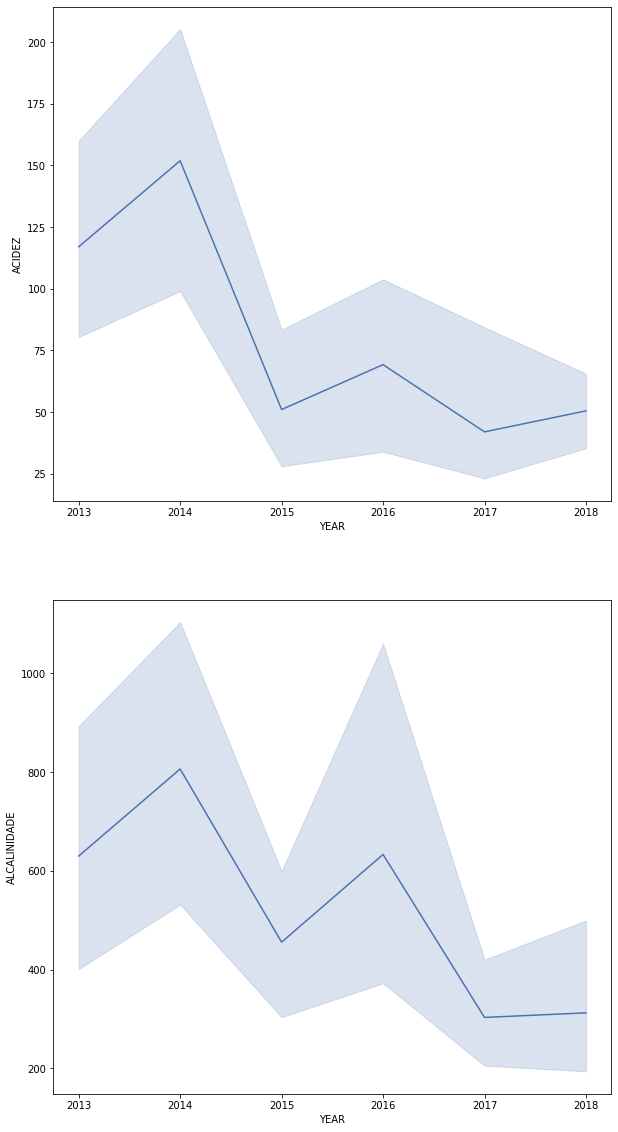

In [10]:
# Plotando séries históricas
fig, axs = plt.subplots(len(cols), 1)
fig.set_figheight(20)

for key, col in enumerate(cols):
    sns.lineplot(
        data=df_ordered, 
        x="YEAR", 
        y=col, 
        estimator="mean",
        ci=95,
        n_boot=100, 
        ax=axs[key]
    );

### Identificando outliers nos dados agregados por ano


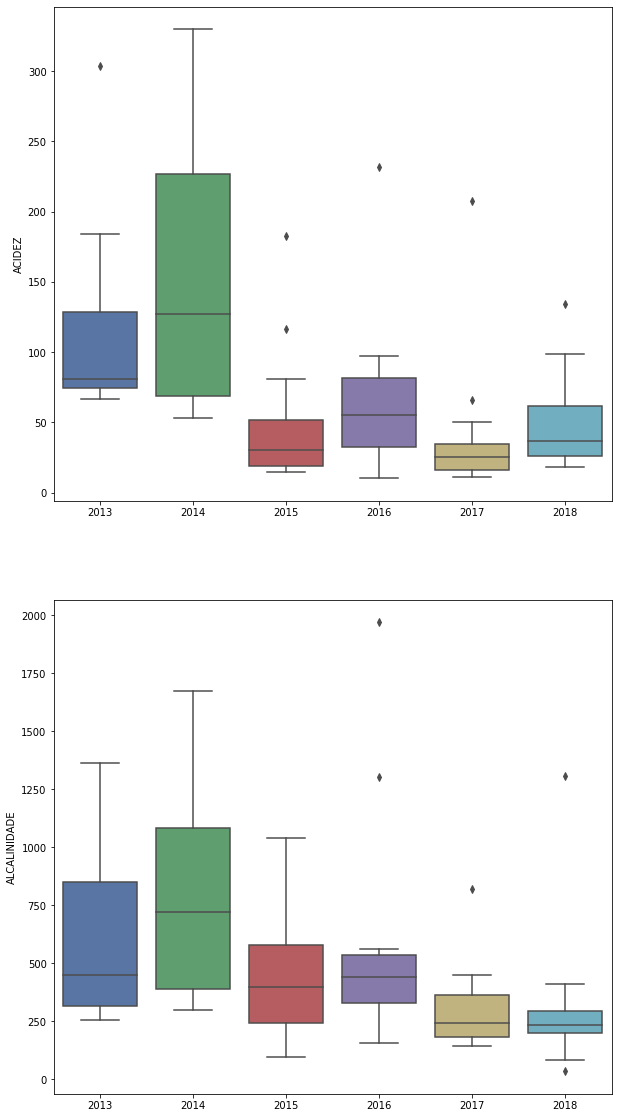

In [11]:
fig, axs = plt.subplots(len(cols), 1)
fig.set_figheight(20)

for key, col in enumerate(cols):
    g = sns.boxplot(
        data=df_ordered, 
        x="YEAR", 
        y=col,  
        ax=axs[key]
    )
    g.set_xlabel("");

# Modelagem de Features

## Limitando Outliers

### Corrigindo outliers para os limites anuais de intervalo interquartil entre 25 e 75%

In [12]:
# Clipar cada outlier baseado no IQR anual da observação
df_clipped = df_ordered.copy()
lower_boundary = df_ordered.groupby("YEAR").quantile(0.25)
lower_boundary.fillna(-inf, inplace=True)
upper_boundary = df_ordered.groupby("YEAR").quantile(0.75)
upper_boundary.fillna(inf, inplace=True)

years = df_ordered.index.year.unique().tolist()
cols = df_ordered.columns[:-1]

for col in cols:
    series = []
    for year in years:
        partial = df_ordered[df_ordered.index.year == year][col].clip(
            lower=lower_boundary[lower_boundary.index == year][col].values[0],
            upper=upper_boundary[upper_boundary.index == year][col].values[0]
        )

        series.append(partial)

    flattened = [val for sublist in series for val in sublist]
    df_clipped[col] = flattened

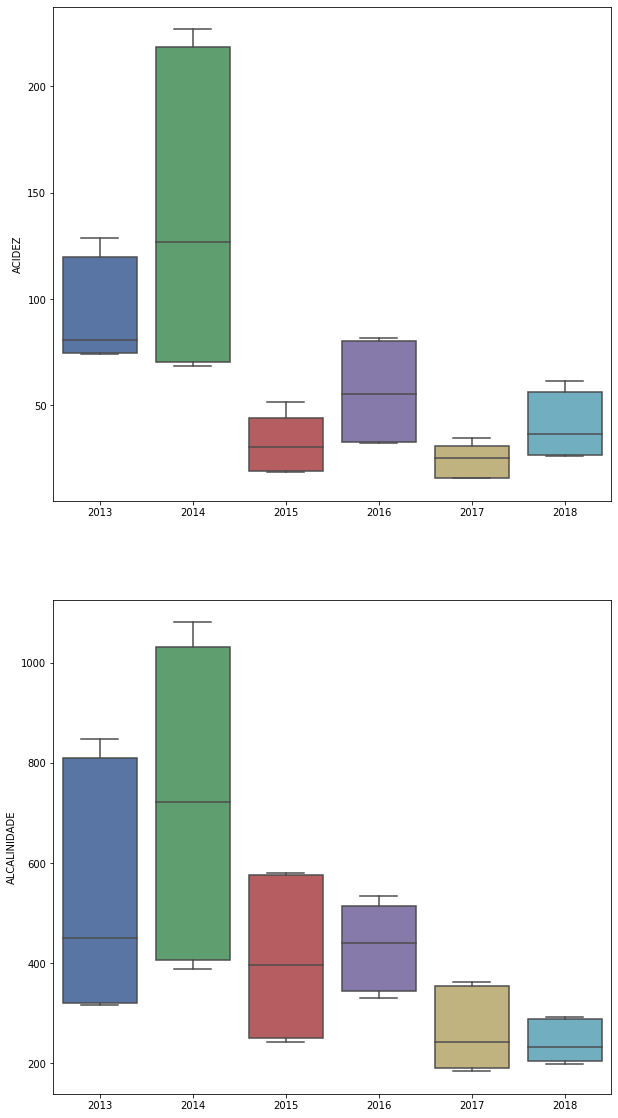

In [13]:
# Plotar boxplot anual de cada coluna
fig, axs = plt.subplots(len(cols), 1)
fig.set_figheight(20)

for key, col in enumerate(cols):
    g = sns.boxplot(
        data=df_clipped, 
        x="YEAR", 
        y=col,  
        ax=axs[key]
    )
    g.set_xlabel("");

### Série Histórica Clipada

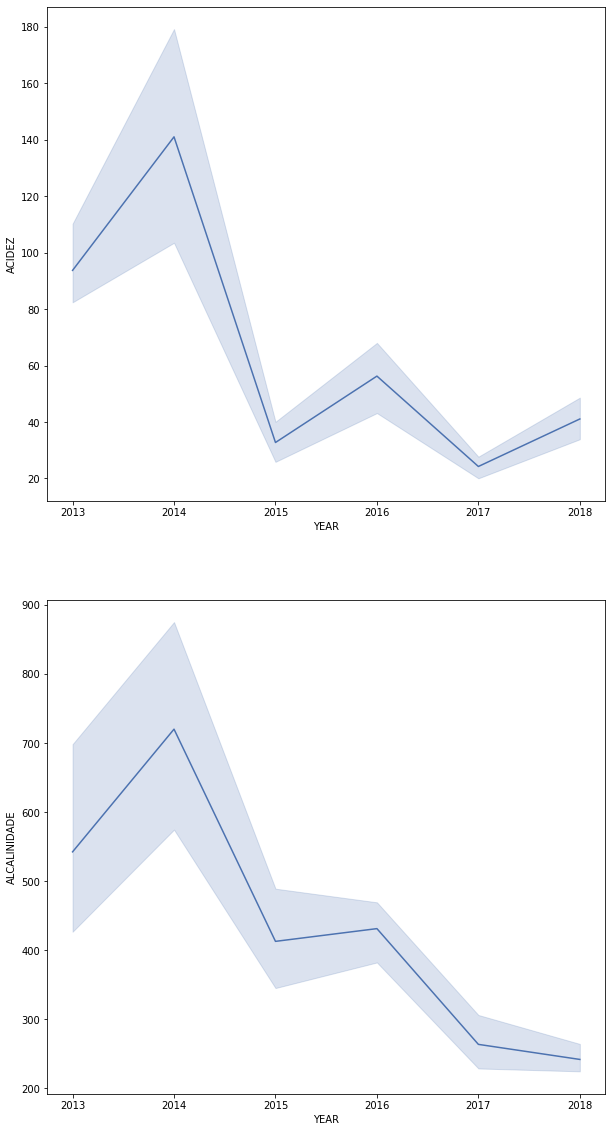

In [14]:
fig, axs = plt.subplots(len(cols), 1)
fig.set_figheight(20)
fig.set_label("")

for key, col in enumerate(cols):
    sns.lineplot(
        data=df_clipped, 
        x="YEAR",
        y=col, 
        estimator="mean",
        ci=95,
        n_boot=100, 
        ax=axs[key]
    );

## Imputando média trimestral nos dados faltantes
Foi verificado que os dados históricos com maior periodicidade possuem no mínimo registros a cada 3-4 meses, portanto será utilizado o número de vizinhos igual a 2.

In [15]:
from sklearn.impute import KNNImputer

imputer = KNNImputer(
    missing_values=np.nan, 
    n_neighbors=2, 
    weights='uniform', 
    metric='nan_euclidean', 
    copy=True
)

df_imputed = pd.DataFrame(imputer.fit_transform(df_clipped), index=df_clipped.index, columns=df_clipped.columns)

## Verificando Normalidade dos Dados Modelados
### Shapiro-Wilk
Realizando o teste Shapiro-Wilk para verificar se os dados são provenientes de uma distribuição normal, considerando $\alpha = 0.01$.

Se Se $p-valor$ > $\alpha$: Falha em rejeitar $H_0$, a série é proveniente de distribuição normal;

Se Se $p-valor$ < $\alpha$: Forte evidência para rejeitar $H_0$, a série não é proveniente de distribuição normal.

In [16]:
from scipy.stats import shapiro 

alpha = 0.01
outcome = pd.DataFrame()
for col in cols:
    test = shapiro(df_imputed[col])
    outcome = outcome.append({
        "column": col, 
        "pass": test[1] < alpha, 
        "p_value": test[1]
    }, ignore_index=True)

print("São provenientes de distro normal: \n", outcome[outcome["pass"] == 0])

São provenientes de distro normal: 
 Empty DataFrame
Columns: [column, p_value, pass]
Index: []


### Teste de Dickey-Fuller aumentado
Verifica o quão dependente uma série temporal é definida por uma tendência (e.g. tempo)

<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/223b7673f7bf871d08b19fb9a3c6ae1f0f619a0b" />
<br/>
<img src="https://wikimedia.org/api/rest_v1/media/math/render/svg/35cd48a299a6ffb3139b214b729353bd3e9be12d" />

Se $p-valor$ > $\alpha$: Falha em rejeitar $H_0$, possui raiz unitária, a série é não estacionária.

Se $p-valor$ < $\alpha$: Há forte evidência para rejeitar $H_0$, não existe raiz unitária do processo, a série é estacionária.

In [17]:
from statsmodels.tsa.stattools import adfuller

alpha = 0.01
outcome = pd.DataFrame()
for col in cols:
    test = adfuller(df_imputed[col])
    outcome = outcome.append({
        "column": col,
        "adf_statistic": test[0],
        "pass": test[1] < alpha, 
        "p_value": test[1]
    }, ignore_index=True)

stationary = outcome[outcome["pass"] == 1].sort_values(by="adf_statistic")
non_stationary = outcome[outcome["pass"] == 0].sort_values(by="adf_statistic")
print("\033[32mSão estacionários: \n\n", stationary)

São estacionários: 

 Empty DataFrame
Columns: [adf_statistic, column, p_value, pass]
Index: []


In [18]:
if len(stationary) != 0:
    df_imputed[stationary.column.values].plot(subplots=True, figsize=(10, 10));

In [19]:
print("\033[34mSão não-estacionários: \n\n", non_stationary, "\n\033[0m")

São não-estacionários: 

    adf_statistic        column   p_value  pass
0 -1.798908       ACIDEZ        0.381004  0.0 
1 -1.229797       ALCALINIDADE  0.660648  0.0  



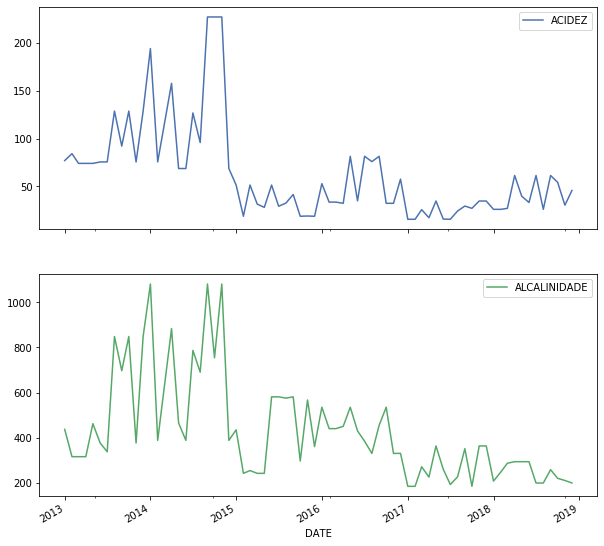

In [20]:
if len(non_stationary) != 0:
    df_imputed[non_stationary.column.values].plot(subplots=True, figsize=(10, 10));

In [21]:
copy2("EDA.ipynb", f"./EDA/EDA_{name}.ipynb")

'./EDA/EDA_reator.ipynb'